# Cube Reprojection Tutorial

This tutorial shows how to take two spectral cubes observed toward the same part of the sky, but different frequencies, and put them onto the same grid.


In this example, we use `dask`, a parallelization framework.


The dask approach can be made more memory-efficient (avoid using too much RAM) by writing intermediate steps to disk.  The non-dask approach will generally need to read the whole cube into memory.

## Index 

 * [Step 1: Download](#Step-1:-Download-the-data)
 * [Step 2: Open files, collect metadata](#Step-2:-Load-the-cubes)
 * [Step 3: Convert to velocity](#Step-3:-Convert-cubes-from-frequency-to-velocity)
 * [Step 4: Spectral Interpolation](#Step-4.-Spectral-Interpolation)
 * [Step 5: Spatial Smoothing](#Step-5.-Spatial-Smoothing)
 * [Step 6: Reprojection](#Step-6.-Reprojection)
 
 
In this example, we do spectral smoothing and interpolation (step 4) before spatial smoothing and interpolation (step 5), but if you have a varying-resolution cube (with a different beam size for each channel), you have to do spatial smoothing first.

## Step 1: Download the data

(you might not have to do this step, since you may already have data)

In [1]:
import numpy as np
from astropy.utils.data import download_file

In [2]:
import warnings
import dask
from dask.diagnostics import ProgressBar

In [3]:
filename_1 = download_file("https://almascience.nrao.edu/dataPortal/member.uid___A001_X1465_X3a33.BrickMaser_sci.spw71.cube.I.manual.image.pbcor.fits",
                           cache=True)
filename_1

'/home/adamginsburg/.astropy/cache/download/url/33718a6f64d8a437fe89bff80278ca22/contents'

In [4]:
filename_2 = download_file("https://almascience.nrao.edu/dataPortal/member.uid___A001_X87d_X141.a_sma1_sci.spw27.cube.I.pbcor.fits",
                          cache=True)
filename_2

'/home/adamginsburg/.astropy/cache/download/url/391fb3a562ec7b94842f7b6e2a55c67e/contents'

## Step 2: Load the cubes

In [5]:
from spectral_cube import SpectralCube

In [6]:
cube1 = SpectralCube.read(filename_1, use_dask=True)
cube1

DaskSpectralCube with shape=(75, 250, 250) and unit=Jy / beam and chunk size (75, 250, 250):
 n_x:    250  type_x: RA---SIN  unit_x: deg    range:   266.534072 deg:  266.554577 deg
 n_y:    250  type_y: DEC--SIN  unit_y: deg    range:   -28.713958 deg:  -28.695975 deg
 n_s:     75  type_s: FREQ      unit_s: Hz     range: 139434992275.503 Hz:139503942362.300 Hz

In [7]:
cube2 = SpectralCube.read(filename_2, use_dask=True)
cube2

DaskSpectralCube with shape=(478, 420, 420) and unit=Jy / beam and chunk size (239, 210, 210):
 n_x:    420  type_x: RA---SIN  unit_x: deg    range:   266.537002 deg:  266.551600 deg
 n_y:    420  type_y: DEC--SIN  unit_y: deg    range:   -28.711371 deg:  -28.698569 deg
 n_s:    478  type_s: FREQ      unit_s: Hz     range: 216957714464.027 Hz:217190639088.700 Hz

Note that with `dask`, a "chunk size" is specified - this will be important later on.

The cubes are at different frequencies - 139 and 89 GHz.

The first cube covers the H2CS 4(1,3)-3(1,2) line at 139.483699	GHz.

The second covers SiO v=5-4 at 217.104984 GHz

In [8]:
cube1.find_lines(chemical_name=' H2CS ').show_in_notebook()

/home/adamginsburg/.local/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/home/adamginsburg/.local/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


idx,Species,Chemical Name,"Freq-GHz(rest frame,redshifted)","Freq Err(rest frame,redshifted)","Meas Freq-GHz(rest frame,redshifted)","Meas Freq Err(rest frame,redshifted)",Resolved QNs,CDMS/JPL Intensity,S<sub>ij</sub>&#956;<sup>2</sup> (D<sup>2</sup>),S<sub>ij</sub>,Log<sub>10</sub> (A<sub>ij</sub>),Lovas/AST Intensity,E_L (cm^-1),E_L (K),E_U (cm^-1),E_U (K),Linelist
0,H2CS,Thioformaldehyde,--,--,139.48341,0.00028,"4(1,3)-3(1,2)",-3.2185,30.51674,11.223,-4.44732,0.17,16.1465,23.23108,20.79917,29.92519,JPL
1,H2CS,Thioformaldehyde,--,--,139.4836816,5e-05,"4(1,3)-3(1,2)",-3.2182,30.59661,11.251,-4.44619,--,16.1329,23.21151,20.78557,29.90563,CDMS
2,H2CS,Thioformaldehyde,139.483699,1.7e-05,139.483741,2.4e-05,"4(1,3)-3(1,2)",0.0,30.59472,3.75,-3.94426,0.17,16.133,23.21165,20.78568,29.90578,SLAIM
3,H2CS,Thioformaldehyde,139.483699,1.7e-05,--,--,"4(1,3)-3(1,2)",0.0,0.0,0.0,0.0,0.17,0.0,0.0,0.0,0.0,Lovas


In [9]:
cube2.find_lines(chemical_name='SiO').show_in_notebook()

idx,Species,Chemical Name,"Freq-GHz(rest frame,redshifted)","Freq Err(rest frame,redshifted)","Meas Freq-GHz(rest frame,redshifted)","Meas Freq Err(rest frame,redshifted)",Resolved QNs,CDMS/JPL Intensity,S<sub>ij</sub>&#956;<sup>2</sup> (D<sup>2</sup>),S<sub>ij</sub>,Log<sub>10</sub> (A<sub>ij</sub>),Lovas/AST Intensity,E_L (cm^-1),E_L (K),E_U (cm^-1),E_U (K),Linelist
0,"SiO,v=0-10",Silicon monoxide (global fit),--,--,217.104919,2e-06,"J=5-4,v=0-0",-1.3211,47.9909,0.0,-3.28429,--,14.4843,20.83981,21.72614,31.25927,CDMS
1,SiOv=0,Silicon Monoxide,--,--,217.10498,8e-05,5-4,-1.3211,47.99147,5.0,-3.28429,1.6,14.4843,20.83956,21.72614,31.25889,CDMS
2,SiOv=0,Silicon Monoxide,--,--,217.10498,5e-05,5-4,-1.3199,47.9911,5.0,-3.28429,1.6,14.4843,20.83956,21.72614,31.25889,CDMS
3,SiOv=0,Silicon Monoxide,--,--,217.10498,8e-05,5-4,-1.3166,48.14651,5.0,-3.28288,1.6,14.4843,20.83956,21.72614,31.25889,JPL
4,SiOv=0,Silicon Monoxide,217.104984,1.4e-05,--,--,5-4,0.0,0.0,0.0,0.0,1.6,0.0,0.0,0.0,0.0,Lovas
5,SiOv=0,Silicon Monoxide,217.104984,1.4e-05,217.10498,0.0001,5-4,0.0,47.6849,5.0,-3.28706,--,14.484,20.83913,21.72584,31.25846,SLAIM


## Step 3: Convert cubes from frequency to velocity

In [10]:
from astropy import units as u

In [11]:
cube1vel = cube1.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=139.483699*u.GHz)
cube1vel

DaskSpectralCube with shape=(75, 250, 250) and unit=Jy / beam and chunk size (75, 250, 250):
 n_x:    250  type_x: RA---SIN  unit_x: deg    range:   266.534072 deg:  266.554577 deg
 n_y:    250  type_y: DEC--SIN  unit_y: deg    range:   -28.713958 deg:  -28.695975 deg
 n_s:     75  type_s: VRAD      unit_s: km / s  range:      -43.509 km / s:     104.685 km / s

In [12]:
cube2vel = cube2.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=217.104984*u.GHz)
cube2vel

DaskSpectralCube with shape=(478, 420, 420) and unit=Jy / beam and chunk size (239, 210, 210):
 n_x:    420  type_x: RA---SIN  unit_x: deg    range:   266.537002 deg:  266.551600 deg
 n_y:    420  type_y: DEC--SIN  unit_y: deg    range:   -28.711371 deg:  -28.698569 deg
 n_s:    478  type_s: VRAD      unit_s: km / s  range:     -118.278 km / s:     203.359 km / s

From the shape of the cube, we can see the H2CS cube is narrower in velocity, so we'll use that as the target spectral reprojection.  However, the SiO cube is the smaller footprint on the sky.

### Do some quicklooks of the peak intensity to see what we expect to see:

INFO: Auto-setting vmin to  2.208e-04 [aplpy.core]
INFO: Auto-setting vmax to  4.069e-02 [aplpy.core]


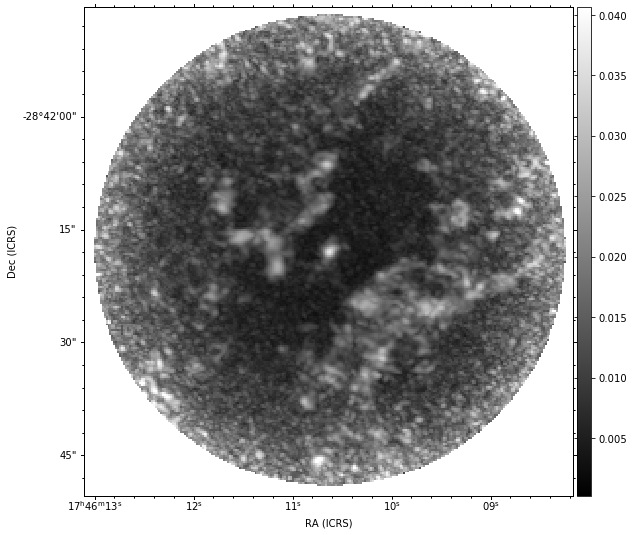

In [13]:
cube1.max(axis=0).quicklook()

INFO: Auto-setting vmin to  9.370e-04 [aplpy.core]
INFO: Auto-setting vmax to  4.991e-02 [aplpy.core]


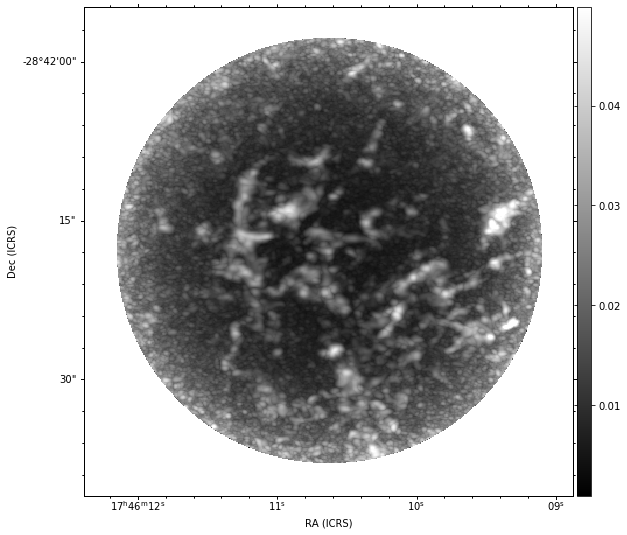

In [14]:
cube2.max(axis=0).quicklook()

# Step 4. Spectral Interpolation

We can do the spatial or spectral step first.  In this case, we choose spectral.

We need to match resolution:

In [15]:
velocity_res_1 = np.diff(cube1vel.spectral_axis)[0]
velocity_res_2 = np.diff(cube2vel.spectral_axis)[0]
velocity_res_1, velocity_res_2

(<Quantity 2.00262828 km / s>, <Quantity 0.67429189 km / s>)

Cube1, our H2CS cube, has broader channels.  We want to smooth cube2 to that channel width before doing the spatial reprojection.

To do this, we'll smooth with a Gaussian with an appropriate FWHM:

In [16]:
fwhm_gaussian = (velocity_res_1**2 - velocity_res_2**2)**0.5
fwhm_gaussian

<Quantity 1.88569628 km / s>

In [17]:
from astropy.convolution import Gaussian1DKernel
fwhm_to_sigma = np.sqrt(8*np.log(2))
# we want the kernel in pixel units, so we force to km/s and take the value
spectral_smoothing_kernel = Gaussian1DKernel(stddev=fwhm_gaussian.to(u.km/u.s).value / fwhm_to_sigma)

Then, let's cut down to the same spectral coverage:

In [18]:
cube2vel_cutout = cube2vel.spectral_slab(cube1vel.spectral_axis.min(), cube1vel.spectral_axis.max())
cube1vel, cube2vel_cutout

(DaskSpectralCube with shape=(75, 250, 250) and unit=Jy / beam and chunk size (75, 250, 250):
  n_x:    250  type_x: RA---SIN  unit_x: deg    range:   266.534072 deg:  266.554577 deg
  n_y:    250  type_y: DEC--SIN  unit_y: deg    range:   -28.713958 deg:  -28.695975 deg
  n_s:     75  type_s: VRAD      unit_s: km / s  range:      -43.509 km / s:     104.685 km / s,
 DaskSpectralCube with shape=(221, 420, 420) and unit=Jy / beam and chunk size (128, 210, 210):
  n_x:    420  type_x: RA---SIN  unit_x: deg    range:   266.537002 deg:  266.551600 deg
  n_y:    420  type_y: DEC--SIN  unit_y: deg    range:   -28.711371 deg:  -28.698569 deg
  n_s:    221  type_s: VRAD      unit_s: km / s  range:      -43.432 km / s:     104.913 km / s)

Note that it is important for the to-be-interpolated cube, in this case `cube2`, to have pixels bouding `cube1`'s spectral axis, but in this case it does not.  If the pixel range doesn't overlap perfectly, it may blank out one of the edge pixels.  So, to fix this, we add a little buffer:

In [19]:
cube2vel_cutout = cube2vel.spectral_slab(cube1vel.spectral_axis.min() - cube2vel.spectral_axis.diff()[0],
                                         cube1vel.spectral_axis.max())
cube1vel, cube2vel_cutout

(DaskSpectralCube with shape=(75, 250, 250) and unit=Jy / beam and chunk size (75, 250, 250):
  n_x:    250  type_x: RA---SIN  unit_x: deg    range:   266.534072 deg:  266.554577 deg
  n_y:    250  type_y: DEC--SIN  unit_y: deg    range:   -28.713958 deg:  -28.695975 deg
  n_s:     75  type_s: VRAD      unit_s: km / s  range:      -43.509 km / s:     104.685 km / s,
 DaskSpectralCube with shape=(222, 420, 420) and unit=Jy / beam and chunk size (129, 210, 210):
  n_x:    420  type_x: RA---SIN  unit_x: deg    range:   266.537002 deg:  266.551600 deg
  n_y:    420  type_y: DEC--SIN  unit_y: deg    range:   -28.711371 deg:  -28.698569 deg
  n_s:    222  type_s: VRAD      unit_s: km / s  range:      -44.106 km / s:     104.913 km / s)

We then smooth with the kernel.  Note that this is doing 420x420 = 176400 smoothing operations on a length-221 spectrum: it will take a little time

In [20]:
cube2vel_smooth = cube2vel_cutout.spectral_smooth(spectral_smoothing_kernel)
cube2vel_smooth

DaskSpectralCube with shape=(222, 420, 420) and unit=Jy / beam and chunk size (222, 210, 210):
 n_x:    420  type_x: RA---SIN  unit_x: deg    range:   266.537002 deg:  266.551600 deg
 n_y:    420  type_y: DEC--SIN  unit_y: deg    range:   -28.711371 deg:  -28.698569 deg
 n_s:    222  type_s: VRAD      unit_s: km / s  range:      -44.106 km / s:     104.913 km / s

Now that we've done spectral smoothing, we can resample the spectrum:

In [21]:
with ProgressBar():
    cube2vel_spectralresample = cube2vel_smooth.spectral_interpolate(cube1vel.spectral_axis)
cube2vel_spectralresample

DaskSpectralCube with shape=(75, 420, 420) and unit=Jy / beam and chunk size (75, 210, 210):
 n_x:    420  type_x: RA---SIN  unit_x: deg    range:   266.537002 deg:  266.551600 deg
 n_y:    420  type_y: DEC--SIN  unit_y: deg    range:   -28.711371 deg:  -28.698569 deg
 n_s:     75  type_s: VRAD      unit_s: km / s  range:      -43.509 km / s:     104.685 km / s

# Step 5. Spatial Smoothing

Now that we've done spectral smoothing, we have to spatially smooth, because we're going to resample the data spatially too

In [22]:
cube1vel.beam, cube2vel_spectralresample.beam

(Beam: BMAJ=1.29719604986604 arcsec BMIN=1.04247149438736 arcsec BPA=82.95313553702 deg,
 Beam: BMAJ=0.8935712308515601 arcsec BMIN=0.6649610689789199 arcsec BPA=85.81119797802 deg)

cube1 again hase the larger beam, so we'll smooth cube2 to its resolution

#### Aside: mixed beams 

If cube1 and cube2 had different sized beams, but neither was clearly larger, we would have to convolve _both_ to a [common beam](https://radio-beam.readthedocs.io/en/latest/commonbeam.html#finding-the-smallest-common-beam).

In this case, it's redundant and we could have just used cube1's beam, but this is the more general approach:

In [23]:
import radio_beam
common_beam = radio_beam.commonbeam.common_2beams(radio_beam.Beams(beams=[cube1vel.beam, cube2vel.beam]))
common_beam

Beam: BMAJ=1.29719604986604 arcsec BMIN=1.04247149438736 arcsec BPA=82.95313553702 deg

In [24]:
cube2vel_spectralresample

DaskSpectralCube with shape=(75, 420, 420) and unit=Jy / beam and chunk size (75, 210, 210):
 n_x:    420  type_x: RA---SIN  unit_x: deg    range:   266.537002 deg:  266.551600 deg
 n_y:    420  type_y: DEC--SIN  unit_y: deg    range:   -28.711371 deg:  -28.698569 deg
 n_s:     75  type_s: VRAD      unit_s: km / s  range:      -43.509 km / s:     104.685 km / s

In [25]:
with ProgressBar():
    cube2vel_spatialspectralsmooth = cube2vel_spectralresample.to(u.K).convolve_to(common_beam)
cube2vel_spatialspectralsmooth

[                                        ] | 0% Completed |  0.1s

[                                        ] | 0% Completed |  2.3s

[##########                              ] | 25% Completed |  4.4s

[####################                    ] | 50% Completed |  6.5s

[##############################          ] | 75% Completed |  8.6s

[########################################] | 100% Completed |  9.0s


DaskSpectralCube with shape=(75, 420, 420) and unit=K and chunk size (75, 420, 420):
 n_x:    420  type_x: RA---SIN  unit_x: deg    range:   266.537002 deg:  266.551600 deg
 n_y:    420  type_y: DEC--SIN  unit_y: deg    range:   -28.711371 deg:  -28.698569 deg
 n_s:     75  type_s: VRAD      unit_s: km / s  range:      -43.509 km / s:     104.685 km / s

# Step 6. Reprojection
Now, finally, we can do the reproject step:

In [26]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    with ProgressBar():
        cube2vel_reproj = cube2vel_spatialspectralsmooth.reproject(cube1vel.header)
cube2vel_reproj

[########################################] | 100% Completed |  3min  2.7s


DaskSpectralCube with shape=(75, 250, 250) and unit=K and chunk size (75, 250, 250):
 n_x:    250  type_x: RA---SIN  unit_x: deg    range:   266.534072 deg:  266.554577 deg
 n_y:    250  type_y: DEC--SIN  unit_y: deg    range:   -28.713958 deg:  -28.695975 deg
 n_s:     75  type_s: VRAD      unit_s: km / s  range:      -43.509 km / s:     104.685 km / s

In [27]:
cube2vel_reproj, cube1vel

(DaskSpectralCube with shape=(75, 250, 250) and unit=K and chunk size (75, 250, 250):
  n_x:    250  type_x: RA---SIN  unit_x: deg    range:   266.534072 deg:  266.554577 deg
  n_y:    250  type_y: DEC--SIN  unit_y: deg    range:   -28.713958 deg:  -28.695975 deg
  n_s:     75  type_s: VRAD      unit_s: km / s  range:      -43.509 km / s:     104.685 km / s,
 DaskSpectralCube with shape=(75, 250, 250) and unit=Jy / beam and chunk size (75, 250, 250):
  n_x:    250  type_x: RA---SIN  unit_x: deg    range:   266.534072 deg:  266.554577 deg
  n_y:    250  type_y: DEC--SIN  unit_y: deg    range:   -28.713958 deg:  -28.695975 deg
  n_s:     75  type_s: VRAD      unit_s: km / s  range:      -43.509 km / s:     104.685 km / s)

These spectra can now be overplotted as they are in the same unit with the same beam.

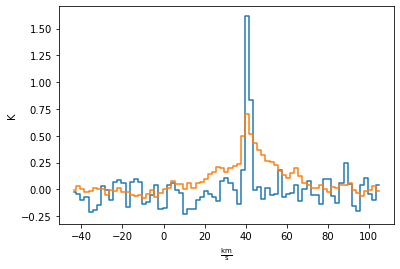

In [28]:
cube1vel[:,125,125].to(u.K).with_spectral_unit(u.km/u.s).quicklook()
cube2vel_reproj[:,125,125].quicklook()